Data Measurement of DESI Legacy Imaging Surveys ELGs and Lenz 2019 CIB Maps. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import copy
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
plt.style.use("seaborn-v0_8-paper")

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Impact of pixel window function

It is known that `LMAX` above `NSIDE` starts feeling the impact of the pixel window function. This test assesses whether `hp.pixwin` can fix the issue, thereby allowing us to increase `LMAX`. 

In [3]:
NSIDE = 1024
LMAX = NSIDE
ells = np.arange(3*NSIDE)
cl = np.ones(3*NSIDE-1)

In [8]:
# generate maps
tstmap = hp.synfast(cl, nside=NSIDE, pol=False)
tstmap_pw = hp.synfast(cl, nside=NSIDE, pol=False,
                    pixwin=True) # with pixel window

In [7]:
# calculate observe C_ells 


cl_npw = hp.anafast(tstmap,pol=False,
                    use_pixel_weights=True,
                    datapath=healpy_path)

cl_pw = hp.anafast(tstmap_pw,pol=False,
                    use_pixel_weights=True,
                    datapath=healpy_path)

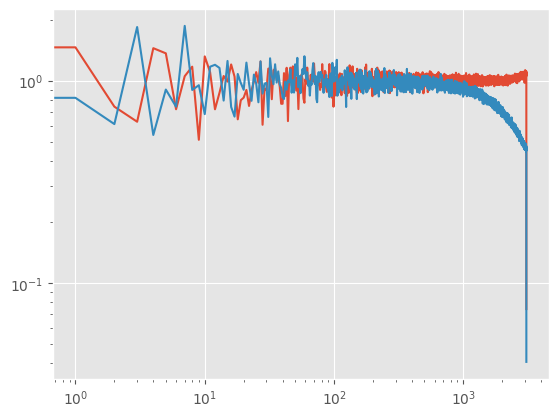

In [10]:
plt.loglog(ells,cl_npw)
plt.loglog(ells,cl_pw)

In [12]:
pw = hp.pixwin(NSIDE,pol=False)

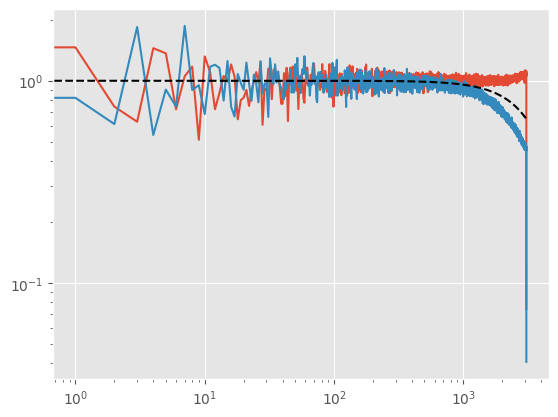

In [15]:
plt.loglog(ells,cl_npw)
plt.loglog(ells,cl_pw)
plt.loglog(ells,pw,c = 'k', ls = '--')

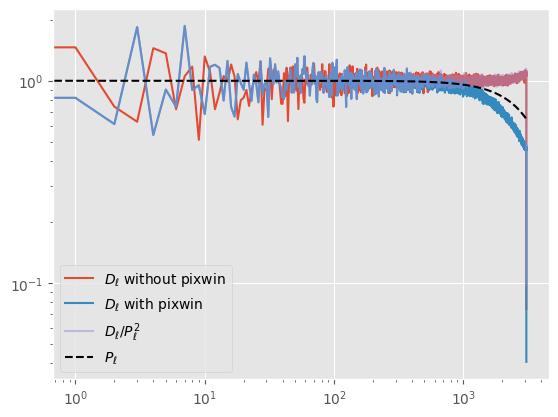

In [23]:
plt.loglog(ells,cl_npw, label=r'$D_{\ell}$ without pixwin')
plt.loglog(ells,cl_pw, label=r'$D_{\ell}$ with pixwin')
plt.loglog(ells,cl_pw/pw**2,
           label=r'$D_{\ell}/P_{\ell}^2$', alpha=0.5)
plt.loglog(ells,pw,c = 'k', ls = '--',
           label=r'$P_{\ell}$')
plt.legend(loc='best')

# Lenz+19 data

In this section we measure the CIB-CIB power spectra based on the Lenz+19 data. 

The fiducial cut we use is $N_{\rm HI}$ column density masking of $2.5 \times 10^{20}$. We also consider other cuts for consistency. 

### Read in data

In [3]:
# parameters 

nulist = ['353', '545', '857']
NSIDE = 1024
LMAX = 1500

pixwin = hp.pixwin(NSIDE,pol=False)
ells = np.arange(LMAX)

data_folder = '/Users/tkarim/research/galCIB/data/cib/cib-lenz19-data/'
nhi_cuts = ['1.5e+20_gp20',
    '1.8e+20_gp20',
    '2.0e+20_gp20',
    '2.5e+20_gp20',
    '3.0e+20_gp40',
    '4.0e+20_gp40']

healpy_data_path = '/Users/tkarim/research/galCIB/data/healpy/'

### $f_{\rm sky}$ as a function of $N_{\rm HI}$

In [5]:
# store fsky 
fsky = {}

for nu in nulist: 
    for nhi in nhi_cuts:
        mask_cib = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_bool.hpx.fits")
        fsky[f"{nu}+{nhi[:-9]}"] = mask_cib.sum()/mask_cib.size
        

In [6]:
fsky

{'353+1.5': 0.10563572247823079,
 '353+1.8': 0.1462740103403727,
 '353+2.0': 0.1638172467549642,
 '353+2.5': 0.18696125348409018,
 '353+3.0': 0.27573243776957196,
 '353+4.0': 0.34415825208028156,
 '545+1.5': 0.1051938533782959,
 '545+1.8': 0.14568209648132324,
 '545+2.0': 0.1631464163462321,
 '545+2.5': 0.18616437911987305,
 '545+3.0': 0.27443424860636395,
 '545+4.0': 0.3422586917877197,
 '857+1.5': 0.10413845380147298,
 '857+1.8': 0.1442279020945231,
 '857+2.0': 0.16150315602620444,
 '857+2.5': 0.1842039426167806,
 '857+3.0': 0.2714933554331462,
 '857+4.0': 0.3382684389750163}

We test the ranges $2.0 < N_{\rm HI} < 4.0 $ as this has the highest sky proportion. 

## Cross-$\nu$ Spectra

Section F of 2210.01049 suggests that we should use the `fullmission` when $\nu \neq \nu'$.

In [7]:
cl_cibxcib_fullmission = {}
cl_cibxcib_fullmission_beam_corrected = {}
fsky_cross = {}

for nhi in nhi_cuts:
    for nu1 in nulist:
        for nu2 in nulist: 
            
            if nu1 == nu2: # ignore nu == nu' because of auto-noise
                continue 
            
            if int(nu1) > int(nu2): # ignore double counting 
                continue
            
            # folder location 
            floc1 = f"{data_folder}/{nu1}/{nhi}"
            floc2 = f"{data_folder}/{nu2}/{nhi}"
            
            # multiply by 1e6 to convert Jy to mJy 
            nu1_map = hp.read_map(f"{floc1}/cib_fullmission.hpx.fits")*1e6
            nu2_map = hp.read_map(f"{floc2}/cib_fullmission.hpx.fits")*1e6

            # read in relevant masks and calculate effective fsky
            mask_bool1 = hp.read_map(f"{floc1}/mask_bool.hpx.fits", dtype=bool)
            mask_bool2 = hp.read_map(f"{floc2}/mask_bool.hpx.fits", dtype=bool)
            mask_bool_eff = mask_bool1 * mask_bool2
            fsky_cross[f'{nu1}x{nu2}+{nhi[:-9]}'] = mask_bool_eff.sum()/len(mask_bool_eff)
            
            mask_apod1 = hp.read_map(f"{floc1}/mask_apod.hpx.fits")
            mask_apod2 = hp.read_map(f"{floc2}/mask_apod.hpx.fits")

            # calculate power spectra
            cl_fullmission = hp.anafast(
                map1=np.where(mask_bool1, nu1_map, 0.) * mask_apod1,
                map2=np.where(mask_bool2, nu2_map, 0.) * mask_apod2,
                datapath=healpy_data_path, 
                use_pixel_weights=True, 
                pol = False)
                
            cl_cibxcib_fullmission[f'{nu1}x{nu2}+{nhi[:-9]}'] = cl_fullmission
            
            # beam correction
            beam1 = pd.read_csv(f'{floc1}/windowfunctions.csv', comment='#')['Wl_eff'].values
            beam2 = pd.read_csv(f'{floc2}/windowfunctions.csv', comment='#')['Wl_eff'].values
            
            cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}+{nhi[:-9]}'] = cl_cibxcib_fullmission[f'{nu1}x{nu2}+{nhi[:-9]}'][:LMAX]/(beam1*beam2)[:LMAX]

#### Measured $C (\ell)$ from Lenz+19 

In [8]:
data_lenz19 = pd.read_csv(f"/Users/tkarim/research/galCIB/data/cib/cib-lenz19-data/Cl_CIB_T1T2.csv",
                          comment="#")

#### Comparison Plot

In [11]:
# frequencies to compare 

nu1 = '545'
nu2 = '857'

In [15]:
pw2048 = hp.pixwin(2048,pol=False)[:LMAX]

(5000.0, 80000.0)

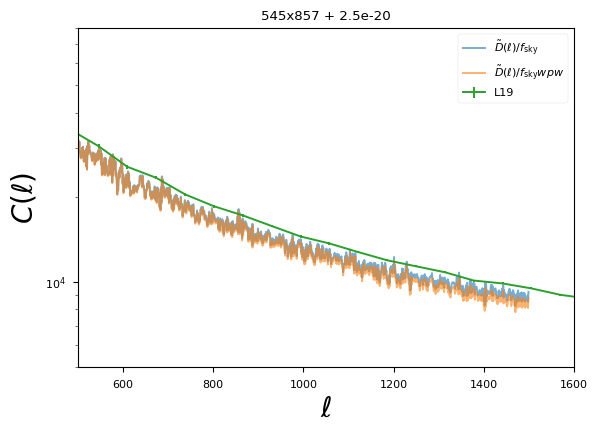

In [22]:
plt.plot(ells, 
         (cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}+2.5']/fsky_cross[f'{nu1}x{nu2}+2.5'])/pw2048**2,
         label = r'$\tilde{D} (\ell)/f_{\rm sky}$',
         alpha = 0.6)

plt.plot(ells, 
         (cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}+2.5']/fsky_cross[f'{nu1}x{nu2}+2.5']),
         label = r'$\tilde{D} (\ell)/f_{\rm sky} wpw$',
         alpha = 0.6)

plt.errorbar(data_lenz19['ell'], data_lenz19[f'{nu1}x{nu2}'], 
             yerr = data_lenz19[f'd{nu1}x{nu2}'],
             label = 'L19')

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f'{nu1}x{nu2} + 2.5e-20')
plt.legend(loc='best')
plt.xlim([500, 1600])
plt.yscale("log")
plt.ylim([5e3, 8e4])


## Auto-$\nu$ Spectra

As per Section F of 2210.01049, for same frequency we have to use odd-even to avoid correlated-noise bias. 

In [23]:
cl_cibxcib_auto = {}
cl_cibxcib_auto_beam_corrected = {}
fsky_auto = {}

for nhi in nhi_cuts:
    for nu in nulist:
            
        # folder location 
        floc = f"{data_folder}/{nu}/{nhi}"
            
        # multiply by 1e6 to convert Jy to mJy 
        odd_map = hp.read_map(f"{floc}/cib_oddring.hpx.fits")*1e6
        even_map = hp.read_map(f"{floc}/cib_evenring.hpx.fits")*1e6

        # read in relevant masks and calculate effective fsky
        mask_bool = hp.read_map(f"{floc}/mask_bool.hpx.fits", dtype=bool)
        fsky_auto[f'{nu}x{nu}+{nhi[:-9]}'] = mask_bool.sum()/len(mask_bool)
        
        # apodized mask    
        mask_apod = hp.read_map(f"{floc}/mask_apod.hpx.fits")

        # calculate power spectra
        cl_auto = hp.anafast(
            map1=np.where(mask_bool, odd_map, 0.) * mask_apod,
            map2=np.where(mask_bool, even_map, 0.) * mask_apod,
            datapath=healpy_data_path, 
            use_pixel_weights=True, 
            pol = False)
            
        cl_cibxcib_auto[f'{nu}x{nu}+{nhi[:-9]}'] = cl_auto
            
        # beam correction
        beam = pd.read_csv(f'{floc}/windowfunctions.csv', comment='#')['Wl_eff'].values
            
        cl_cibxcib_auto_beam_corrected[f'{nu}x{nu}+{nhi[:-9]}'] = cl_cibxcib_auto[f'{nu}x{nu}+{nhi[:-9]}'][:LMAX]/(beam**2)[:LMAX]

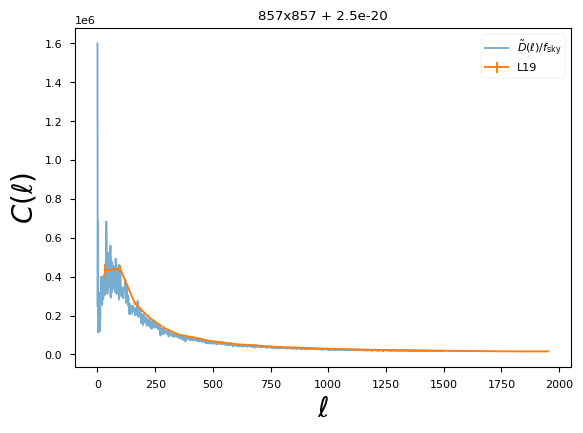

In [31]:
nu = '857'

plt.plot(ells, 
         (cl_cibxcib_auto_beam_corrected[f'{nu}x{nu}+2.5']/fsky_auto[f'{nu}x{nu}+2.5'])/pw2048**2,
         label = r'$\tilde{D} (\ell)/f_{\rm sky}$',
         alpha = 0.6)

# plt.plot(ells, 
#          (cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}+2.5']/fsky_cross[f'{nu1}x{nu2}+2.5']),
#          label = r'$\tilde{D} (\ell)/f_{\rm sky} wpw$',
#          alpha = 0.6)

plt.errorbar(data_lenz19['ell'], data_lenz19[f'{nu}x{nu}'], 
             yerr = data_lenz19[f'd{nu}x{nu}'],
             label = 'L19')

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f'{nu}x{nu} + 2.5e-20')
plt.legend(loc='best')
# plt.xlim([500, 1600])
# plt.yscale("log")
# plt.ylim([5e3, 8e4])


In [ ]:
(cl_cibxcib_fullmission_beam_corrected[f'{nu1}x{nu2}+2.5']/fsky_cross[f'{nu1}x{nu2}+2.5'])/pw2048**2,

In [40]:
cl_cibxcib_fullmission_beam_corrected

dict_keys(['353x545+1.5', '353x857+1.5', '545x857+1.5', '353x545+1.8', '353x857+1.8', '545x857+1.8', '353x545+2.0', '353x857+2.0', '545x857+2.0', '353x545+2.5', '353x857+2.5', '545x857+2.5', '353x545+3.0', '353x857+3.0', '545x857+3.0', '353x545+4.0', '353x857+4.0', '545x857+4.0'])

In [42]:
np.save("/Users/tkarim/research/galCIB/data/measurements/cl_cibxcib_fullmission_beam_corrected.npy",
        cl_cibxcib_fullmission_beam_corrected)

np.save("/Users/tkarim/research/galCIB/data/measurements/cl_cibxcib_auto_beam_corrected.npy",
        cl_cibxcib_auto_beam_corrected)

## Rotate L19 to cross-correlate with DESI

Test 1: Rotate mask in alm space from G to C and `alm2map` with NSIDE = 1024. 

In [20]:
nu = '353'
nhi = nhi_cuts[3]
print(nhi)

mask_apod = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_apod.hpx.fits")
mask_bool = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_bool.hpx.fits")
map_fm = hp.read_map(f"{data_folder}/{nu}/{nhi}/cib_fullmission.hpx.fits")

2.5e+20_gp20


In [22]:
fsky = mask_bool.sum()/mask_bool.size
fsky

0.18696125348409018

In [23]:
# effective map 
map_eff = np.where(mask_bool, map_fm, 0.) * mask_apod

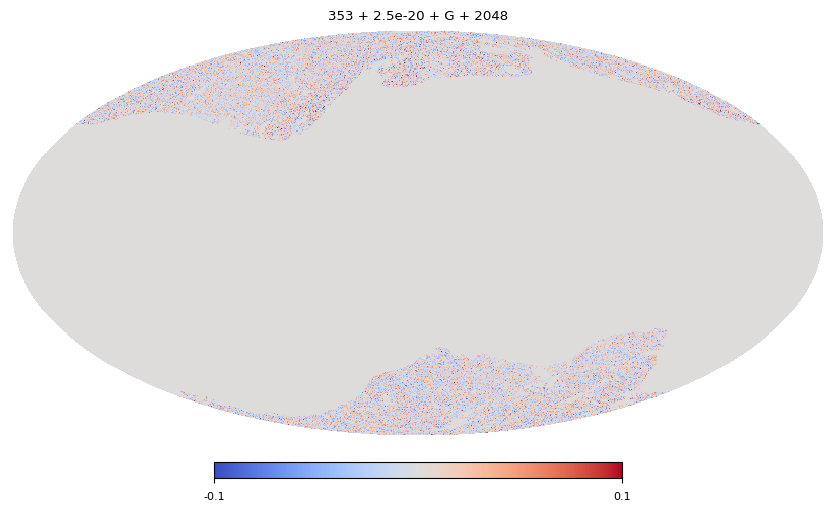

In [26]:
hp.mollview(map_eff, title = '353 + 2.5e-20 + G + 2048',
            min=-0.1,max=0.1,cmap='coolwarm')

In [27]:
# calculate native Cl 

Cl_true = hp.anafast(map_eff,
                     pol=False,
                     use_pixel_weights=True,
                     datapath=healpy_data_path)

In [32]:
LMIN=50; LMAX = 1500
ells = np.arange(LMIN, LMAX)

Text(0.5, 1.0, '353 + 2.5e-20 + G + 2048')

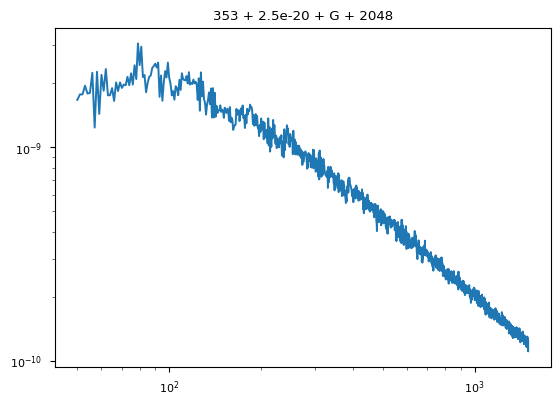

In [34]:
plt.loglog(ells,Cl_true[LMIN:LMAX])
plt.title("353 + 2.5e-20 + G + 2048")

In [ ]:
mask_apod = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_apod.hpx.fits")
mask_bool = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_bool.hpx.fits")
map_fm = hp.read_map(f"{data_folder}/{nu}/{nhi}/cib_fullmission.hpx.fits")

In [35]:

healpy_data_path = '/Users/tkarim/research/galCIB/data/healpy/'

In [36]:
# convert map to alm
alm_map_eff_g_2048 = hp.map2alm(map_eff,pol=False,
                         use_pixel_weights=True,
                         datapath=healpy_data_path)

In [37]:
# rotate alm
alm_map_eff_c_2048 = r.rotate_alm(alm_map_eff_g_2048)

In [38]:
# convert alm to map 
map_eff_c_1024 = hp.alm2map(alm_map_eff_c_2048,
                            nside=1024,pol=False)

In [39]:
# calculate Cl from this rotation 

Cl_rotated_from_eff_to_c_1024 = hp.anafast(map_eff_c_1024,
                                           pol=False,
                                           use_pixel_weights=True,
                                           datapath=healpy_data_path)

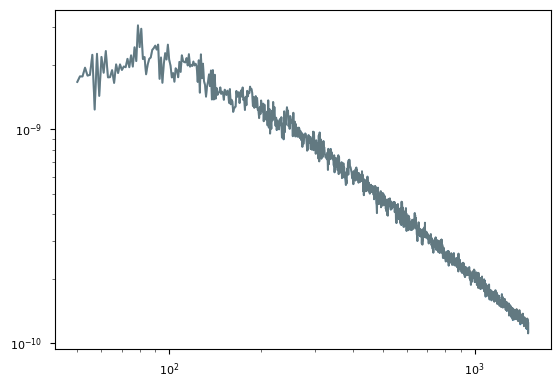

In [41]:
plt.loglog(ells,Cl_true[LMIN:LMAX],
           label="353 + 2.5e-20 + G + 2048")
plt.loglog(ells,Cl_rotated_from_eff_to_c_1024[LMIN:LMAX],
           label='Eff rotated to C + 1024',
           alpha=0.3)

Text(0.5, 1.0, '353 + 2.5e-20 + G + 2048')

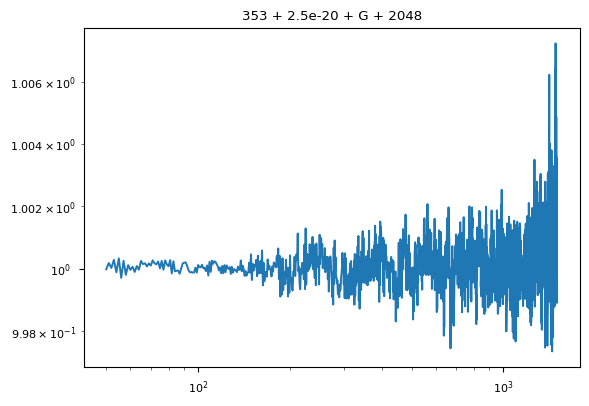

In [70]:
# ratio plot 

ratio = Cl_rotated_from_eff_to_c_1024[LMIN:LMAX]/Cl_true[LMIN:LMAX]
plt.loglog(ells, ratio)
plt.title("353 + 2.5e-20 + G + 2048")

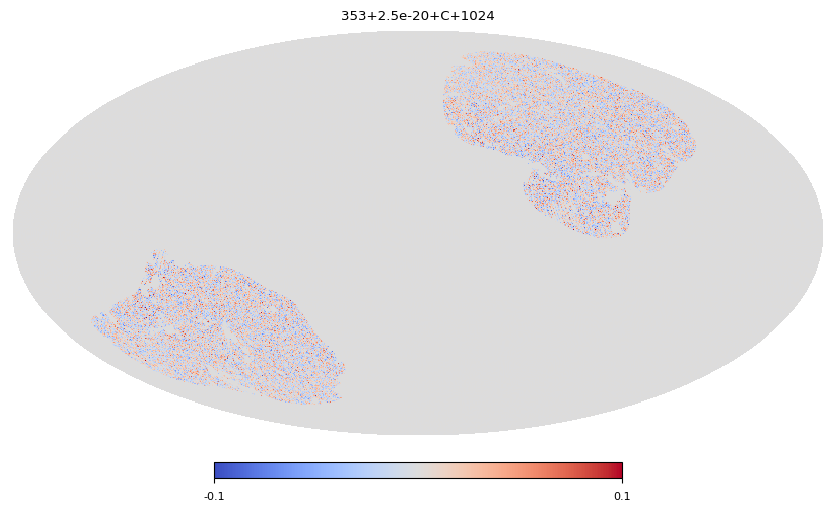

In [44]:
hp.mollview(map_eff_c_1024, rot=-85,
            min=-0.1,max=0.1,cmap='coolwarm',
            title='353+2.5e-20+C+1024')

In [68]:
tst = hp.mask_bad(map_eff_c_1024,
            badval=0,atol=1e-5)

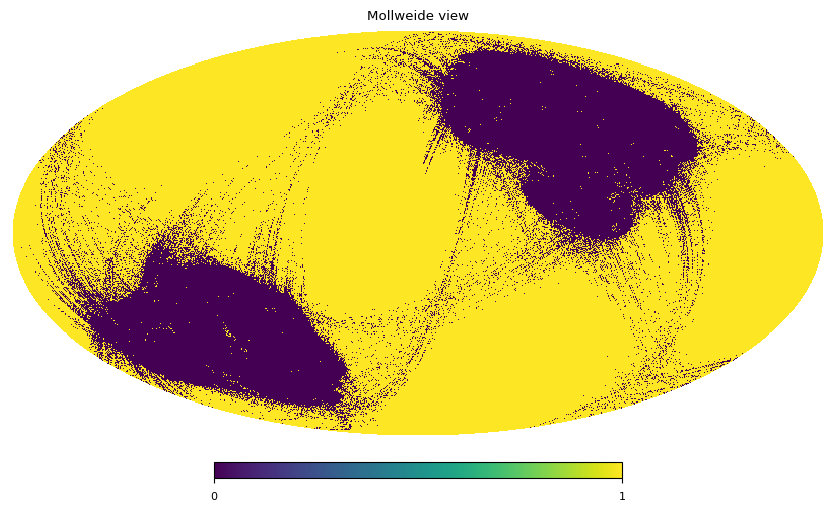

In [69]:
hp.mollview(tst, rot=-85)

In [71]:
mask_bool_pixel_rot = r.rotate_map_pixel(mask_bool)

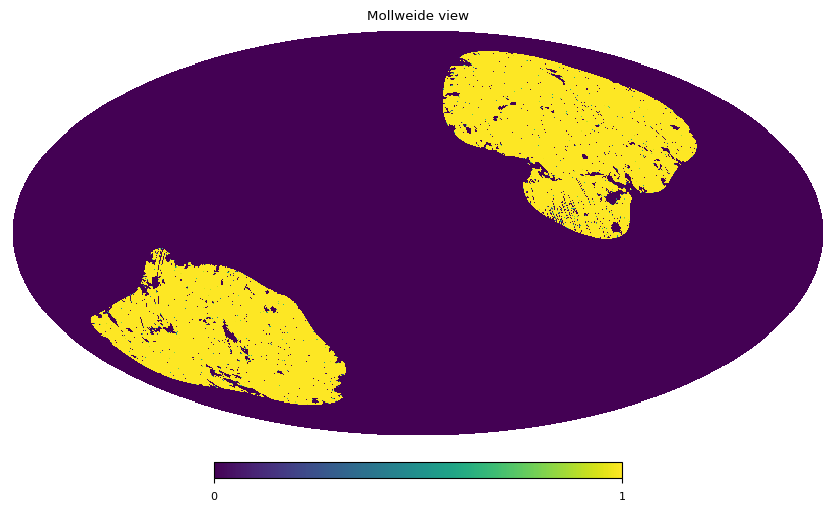

In [73]:
hp.mollview(mask_bool_pixel_rot, rot = -85)

In [78]:
mask_bool_pixel_rot.sum()/mask_bool_pixel_rot.size

0.186961260710194

In [79]:
mask_bool.sum()/mask_bool.size

0.18696125348409018

In [84]:
mask_bool_pixel_rot_udgrade_1024 = hp.ud_grade(mask_bool_pixel_rot,
                                               1024)
# rebinarize
mask_bool_pixel_rot_udgrade_1024 = np.where(mask_bool_pixel_rot_udgrade_1024>0.95,
                                            1,0)

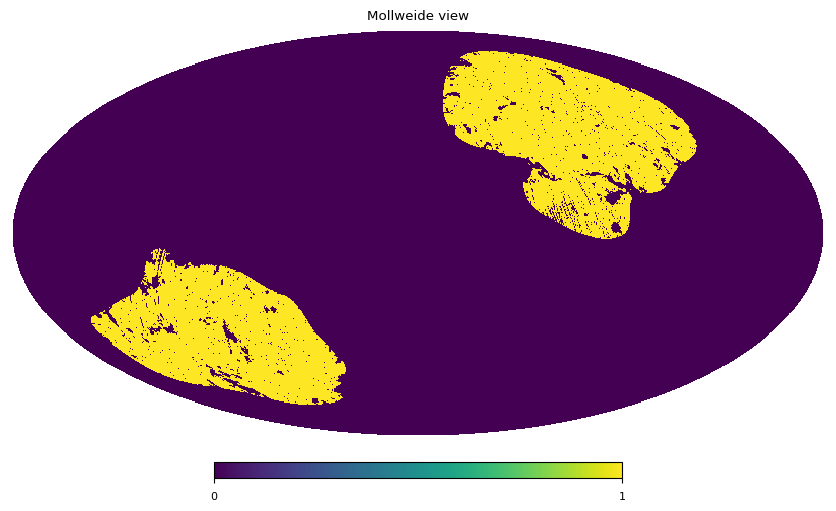

In [85]:
hp.mollview(mask_bool_pixel_rot_udgrade_1024,rot=-85)

In [97]:
fsky_ud = mask_bool_pixel_rot_udgrade_1024.sum()/mask_bool_pixel_rot_udgrade_1024.size
print(f'fsky rotated in C + udgrade 1024 = {fsky_ud}')

fsky_rot = mask_bool_pixel_rot.sum()/mask_bool_pixel_rot.size
print(f'fsky rotated in C + 2048 = {fsky_rot}')

fsky_true = mask_bool.sum()/mask_bool.size
print(f'fsky native in G + 2048 = {fsky_true}')

fsky rotated in C + udgrade 1024 = 0.18420648574829102
fsky rotated in C + 2048 = 0.186961260710194
fsky native in G + 2048 = 0.18696125348409018


In [88]:
import pymaster as nmt

In [89]:
# reapodize 

mask_apod_rot_1024 = nmt.mask_apodization(mask_bool_pixel_rot_udgrade_1024, 
                                          0.25, "C2")

In [91]:
map_eff_c_1024_re_apod = np.where(mask_bool_pixel_rot_udgrade_1024,
                                  map_eff_c_1024,
                                  0)*mask_apod_rot_1024

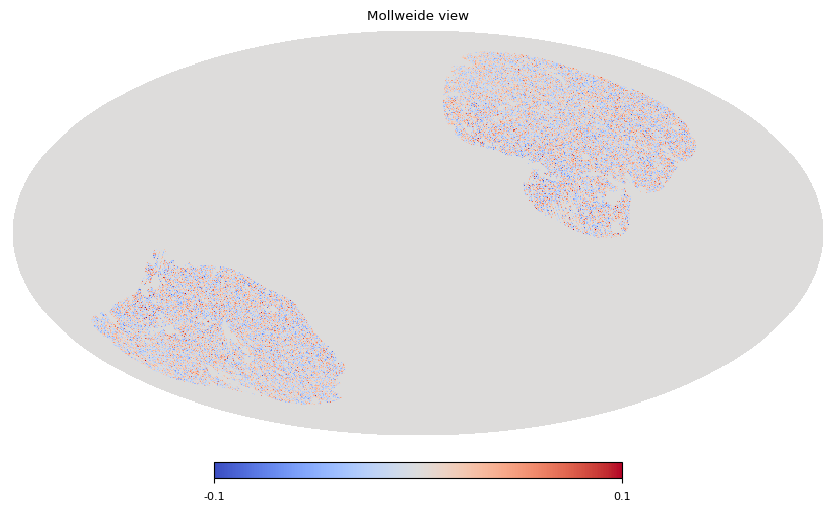

In [93]:
hp.mollview(map_eff_c_1024_re_apod,
            rot=-85,
            min=-0.1,max=0.1,
            cmap='coolwarm')

In [94]:
Cl_c_1024_re_apod = hp.anafast(map_eff_c_1024_re_apod,
                               pol=False,
                               use_pixel_weights=True,
                               datapath=healpy_data_path)

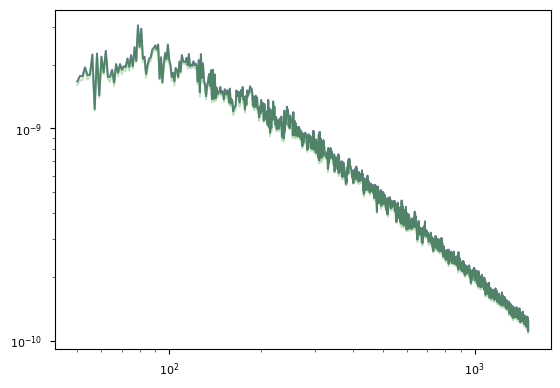

In [95]:
plt.loglog(ells,Cl_true[LMIN:LMAX],
           label="353 + 2.5e-20 + G + 2048")
plt.loglog(ells,Cl_rotated_from_eff_to_c_1024[LMIN:LMAX],
           label='Eff rotated to C + 1024',
           alpha=0.3)

plt.loglog(ells,Cl_c_1024_re_apod[LMIN:LMAX],
           label='C + 1024 re apod',
           alpha=0.3)

Text(0.5, 1.0, 're apod compare with true')

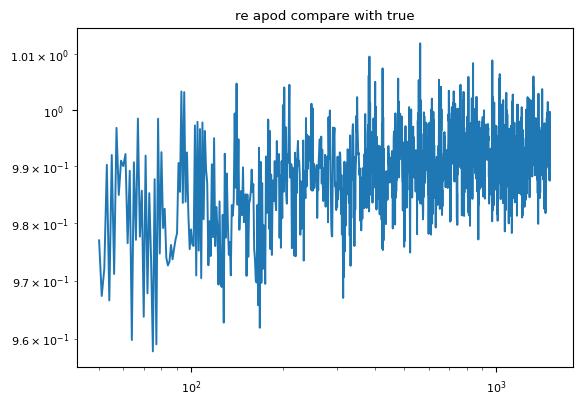

In [100]:
# ratio plot 

ratio = Cl_c_1024_re_apod[LMIN:LMAX]/Cl_true[LMIN:LMAX]
plt.loglog(ells, ratio * fsky_true/fsky_ud)
plt.title("re apod compare with true")

In [101]:
fsky_true/fsky_ud

1.014954781448702

In [107]:
ratio.mean()

0.9757253167471793

Text(0.5, 1.0, 'Comparison of power spectra')

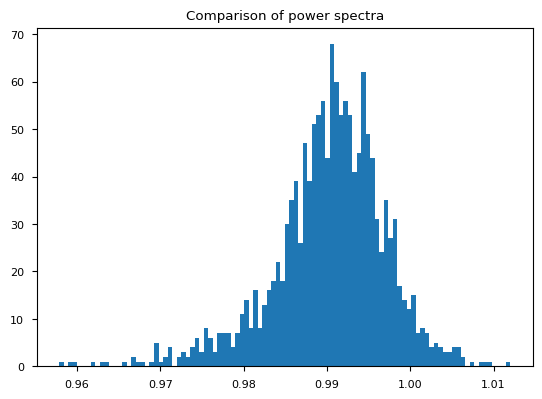

In [111]:
plt.hist(ratio * fsky_true/fsky_ud,
         bins=100);
plt.title("Comparison of power spectra")

In [120]:
map_eff_c_1024_re_apod[~mask_bool_pixel_rot_udgrade_1024.astype(bool)] = hp.UNSEEN

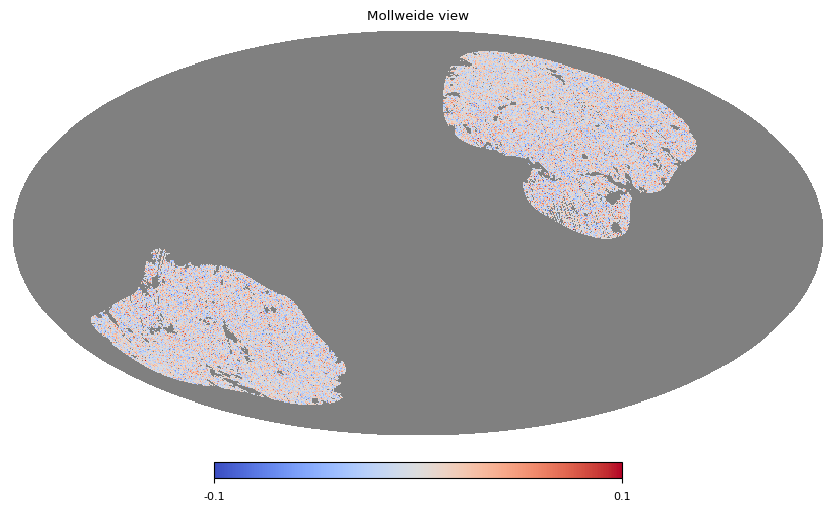

In [121]:
hp.mollview(map_eff_c_1024_re_apod,
            rot=-85,
            min=-0.1,max=0.1,
            cmap='coolwarm')

In [122]:
Cl_c_1024_re_apod_UNSEEN = hp.anafast(map_eff_c_1024_re_apod,
                               pol=False,
                               use_pixel_weights=True,
                               datapath=healpy_data_path)

Text(0.5, 1.0, 're apod compare with true')

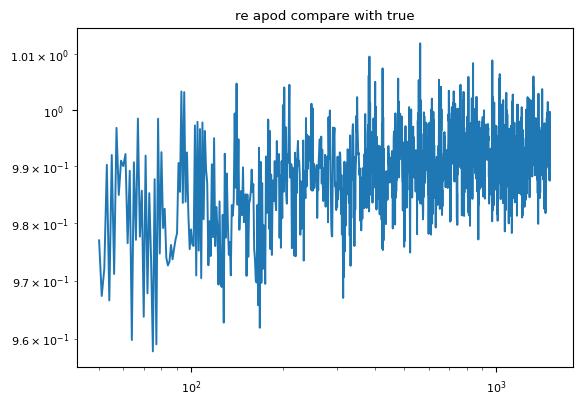

In [123]:
# ratio plot 

ratio = Cl_c_1024_re_apod_UNSEEN[LMIN:LMAX]/Cl_true[LMIN:LMAX]
plt.loglog(ells, ratio * fsky_true/fsky_ud)
plt.title("re apod compare with true")

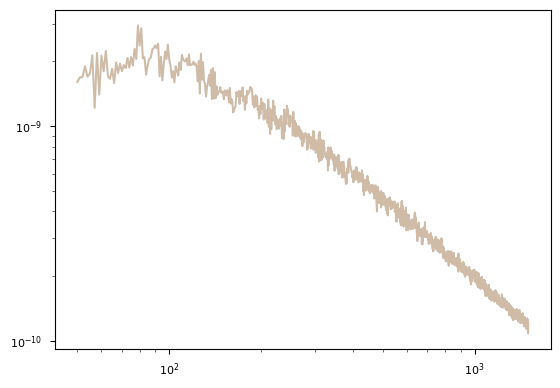

In [124]:
# plt.loglog(ells,Cl_true[LMIN:LMAX],
#            label="353 + 2.5e-20 + G + 2048")
# plt.loglog(ells,Cl_rotated_from_eff_to_c_1024[LMIN:LMAX],
#            label='Eff rotated to C + 1024',
#            alpha=0.3)

plt.loglog(ells,Cl_c_1024_re_apod[LMIN:LMAX],
           label='C + 1024 re apod',
           alpha=0.3)

plt.loglog(ells,Cl_c_1024_re_apod_UNSEEN[LMIN:LMAX],
           label='C + 1024 re apod',
           alpha=0.3)

In [4]:
# mask for CIB footprint
cibmasks_gal = {}

for nu in nulist:
    for nhi in nhi_cuts:
        cibmasks_gal[f'{nu}+{nhi[:-9]}'] = hp.read_map(f"{data_folder}/{nu}/{nhi}/mask_bool.hpx.fits")

As an example use 353 with 1.5 cut. 

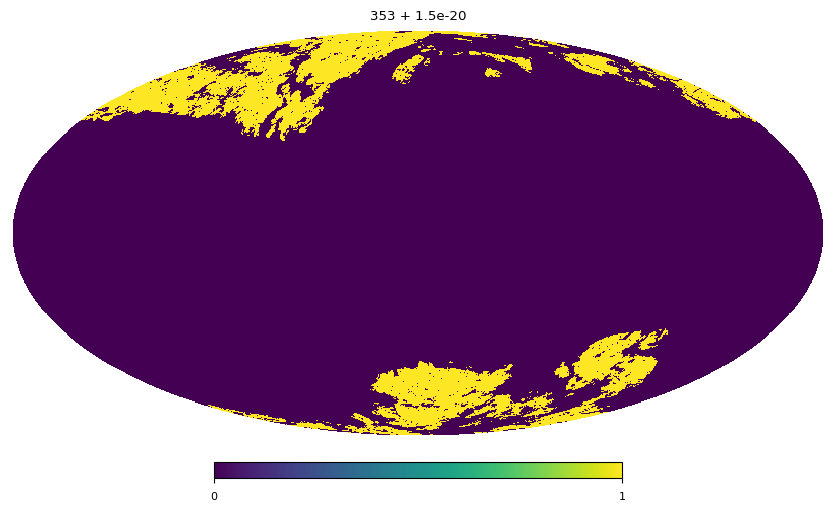

In [5]:
hp.mollview(cibmasks_gal['353+1.5'],
            title='353 + 1.5e-20')

In [126]:
nmt.__version__

'2.2.1'

In [6]:
print(f"fsky in native resolution = {cibmasks_gal['353+1.5'].sum()/cibmasks_gal['353+1.5'].size}")

fsky in native resolution = 0.10563572247823079


In [8]:
# apply rotation
mask_g_2048 = cibmasks_gal['353+1.5']
mask_c_2048 = r.rotate_map_alms(mask_g_2048, 
                                use_pixel_weights=True, 
                                datapath=healpy_data_path)

Check fsky comparison

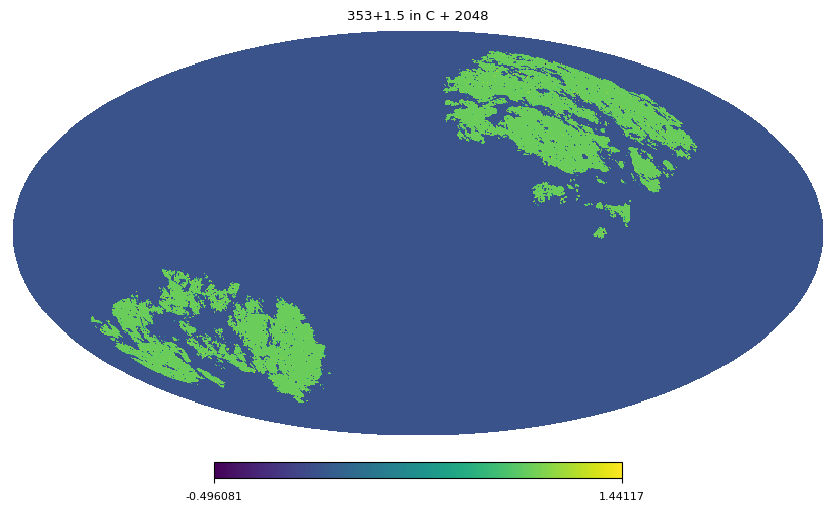

In [10]:
hp.mollview(mask_c_2048, rot=-85,
            title='353+1.5 in C + 2048')

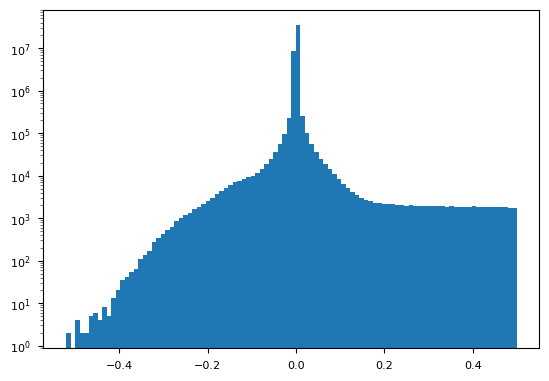

In [17]:
plt.hist(mask_c_2048[mask_c_2048<0.5],bins=100);
plt.yscale("log")

In [ ]:
# measure Cls and compare 

Cl_g_2048 = hp.anafast(mask_g_2048,pol=False,
                       use_pixel_weights=True,
                       datapath=healpy_data_path)

In [54]:
# rotate CIB masks
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
healpy_data_path = '/Users/tkarim/research/galCIB/data/healpy/'

# CIB mask in equatorial
cibmasks_eq = {}

for nu in nulist:
    print(nu)
    for nhi in nhi_cuts:
        cibmask_alm = hp.map2alm(cibmasks_gal[f'{nu}+{nhi[:-9]}'], 
                                 pol = False)
        cibmask_alm_eq = r.rotate_alm(cibmask_alm)
        cibmasks_eq[f'{nu}+{nhi[:-9]}'] = hp.alm2map(cibmask_alm_eq, 
                                                     nside=NSIDE, 
                                                     pol = False)

353
545
857


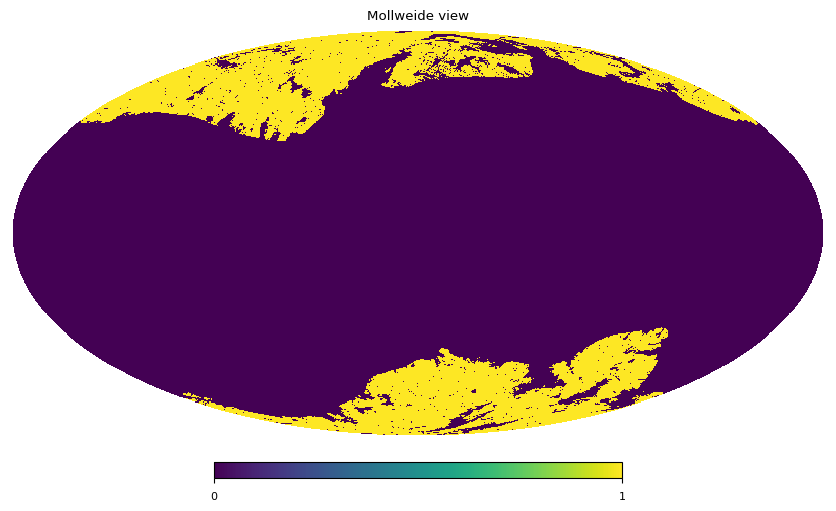

In [75]:
hp.mollview(cibmasks_gal['353+2.0'])

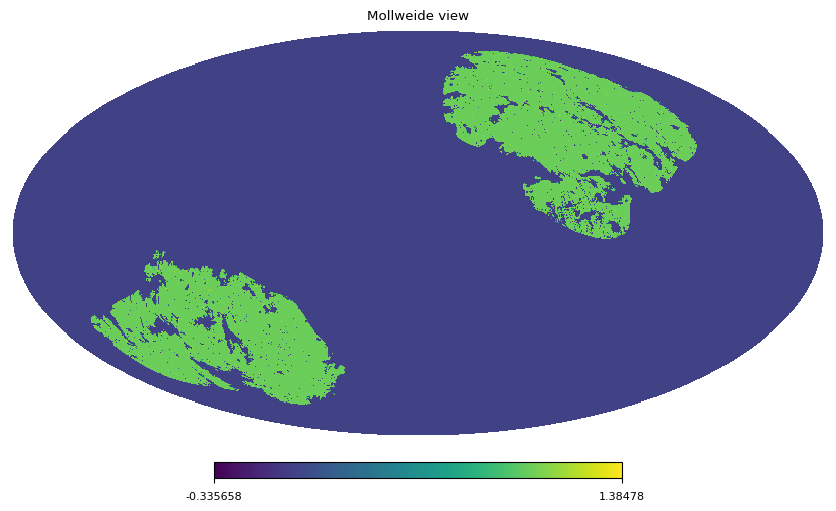

In [77]:
hp.mollview(cibmasks_eq['353+2.0'],
            rot=-85)

In [78]:
tstg = hp.anafast(cibmasks_gal['545+2.0'],
                  pol=False,
                  use_pixel_weights=True,
                  datapath=healpy_data_path)

tste = hp.anafast(cibmasks_eq['545+2.0'],
                  pol=False,
                  use_pixel_weights=True,
                  datapath=healpy_data_path)

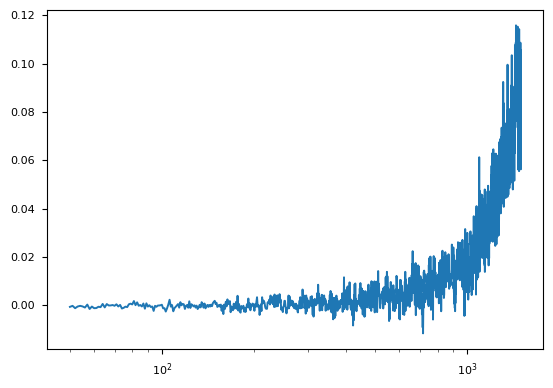

In [81]:
LMIN=50
tste_pw = tste[LMIN:LMAX]#/pw1024[:LMAX]**2
tstg_pw = tstg[LMIN:LMAX]#/pw2048[:LMAX]**2
plt.semilogx(ells[LMIN:LMAX],
           (tste_pw/tstg_pw - 1))

In [93]:
tstg[LMIN:LMAX]/pw2048[LMIN:LMAX]**2

array([3.11972572e-05, 2.29121681e-05, 2.02432557e-05, ...,
       3.90640337e-09, 3.86512755e-09, 3.79461167e-09])

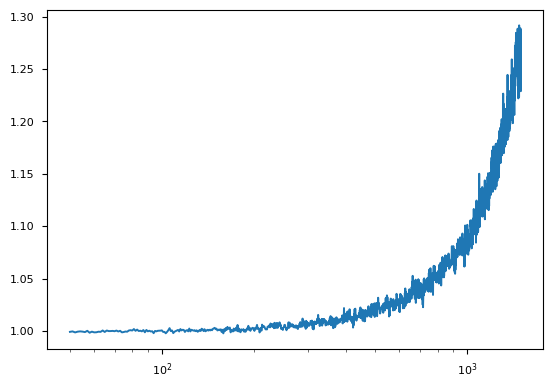

In [95]:
plt.semilogx(ells[LMIN:LMAX],
             ((tste/pw1024**2)[LMIN:LMAX])/(tstg[LMIN:LMAX]/pw2048[LMIN:LMAX]**2)
)

In [ ]:
# rotate CIB masks
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
healpy_data_path = '/Users/tkarim/research/galCIB/data/healpy/'

# CIB mask in equatorial
cibmasks_eq = {}

for nu in nulist:
    print(nu)
    for nhi in nhi_cuts:
        cibmask_alm = hp.map2alm(cibmasks_gal[f'{nu}+{nhi[:-9]}'], 
                                 pol = False)
        cibmask_alm_eq = r.rotate_alm(cibmask_alm)
        cibmasks_eq[f'{nu}+{nhi[:-9]}'] = hp.alm2map(cibmask_alm_eq, 
                                                     nside=NSIDE, 
                                                     pol = False)

In [164]:
nu = '353'
nhi = nhi_cuts[3]
print(nhi)
tmp_alm = hp.map2alm(
    cibmasks_gal[f'{nu}+{nhi[:-9]}'], 
    pol = False,
    use_pixel_weights=True,
    datapath=healpy_data_path,
    lmax=LMAX)

2.5e+20_gp20


In [165]:
tmp_gal_1024 = hp.alm2map(tmp_alm, 
                          nside=NSIDE, 
                        pol = False)

In [166]:
tmp_cl_gal_1024 = hp.anafast(tmp_gal_1024,
                             pol=False,
                             use_pixel_weights=True,
                             datapath=healpy_data_path)

tmp_cl_gal_2048 = hp.anafast(cibmasks_gal[f'{nu}+{nhi[:-9]}'],
                             pol=False,
                             use_pixel_weights=True,
                             datapath=healpy_data_path)

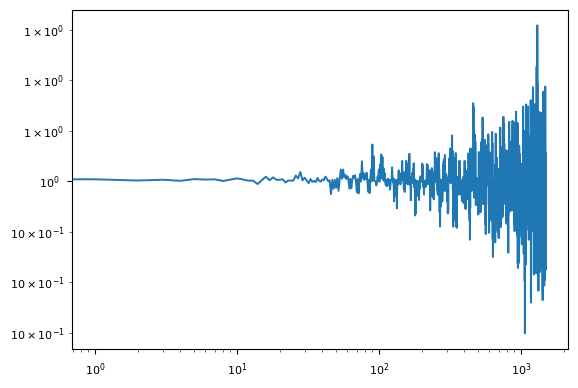

In [169]:
plt.loglog(
    tmp_cl_gal_1024[:LMAX]/tmp_cl_gal_2048[:LMAX]
    )


In [172]:
tmp_alm_eq = r.rotate_alm(tmp_alm)
tmp_alm_eq_lmax = r.rotate_alm(tmp_alm,
                          lmax=LMAX)

In [174]:
tmp_eq_1024 = hp.alm2map(tmp_alm_eq, 
                          nside=NSIDE, 
                        pol = False)

tmp_eq_1024_lmax = hp.alm2map(tmp_alm_eq_lmax, 
                          nside=NSIDE, 
                        pol = False)

In [175]:
tmp_cl_eq_1024 = hp.anafast(tmp_eq_1024,
                             pol=False,
                             use_pixel_weights=True,
                             datapath=healpy_data_path)

tmp_cl_eq_1024_lmax = hp.anafast(tmp_eq_1024_lmax,
                             pol=False,
                             use_pixel_weights=True,
                             datapath=healpy_data_path)

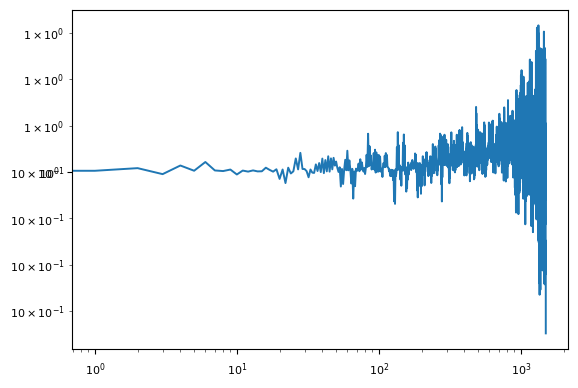

In [178]:
plt.loglog(
    tmp_cl_eq_1024_lmax[:LMAX]/tmp_cl_gal_2048[:LMAX]
    )


In [179]:
tmp_cl_eq_1024_lmax[:LMAX]/tmp_cl_gal_2048[:LMAX]

array([1., 1., 1., ..., 1., 1., 1.])

In [180]:
cibmasks_eq['']

{'353+1.5': array([-1.97555154e-04, -1.82821120e-04, -4.78719987e-05, ...,
        -1.35278567e-04, -4.75092408e-04,  2.39790285e-04]),
 '353+1.8': array([ 4.35035461e-04, -9.95854788e-05, -3.61539945e-04, ...,
         2.18685136e-04,  4.02106990e-04,  3.88701119e-04]),
 '353+2.0': array([-1.48455927e-04, -5.36122066e-05,  2.75008710e-04, ...,
         2.91349337e-04,  7.50758750e-06,  2.80907053e-04]),
 '353+2.5': array([ 4.00929627e-05, -3.37660581e-05, -8.44339641e-05, ...,
        -2.05681558e-04, -7.77154512e-05, -6.37713045e-05]),
 '353+3.0': array([-0.00028435, -0.0014344 ,  0.00065506, ..., -0.00053306,
        -0.00025317, -0.00048537]),
 '353+4.0': array([-0.00061101, -0.00037025,  0.00067484, ...,  0.00010832,
        -0.00073324, -0.00028332]),
 '545+1.5': array([-1.46498911e-04, -1.68165330e-04, -3.86044560e-05, ...,
        -8.46308449e-05, -4.94541758e-04,  1.44225616e-04]),
 '545+1.8': array([ 0.00055552, -0.00013467, -0.00049006, ...,  0.00031777,
         0.00034523,

In [116]:
pw1024 = hp.pixwin(1024,pol=False,
                   )
pw2048 = hp.pixwin(2048,pol=False,
                   )

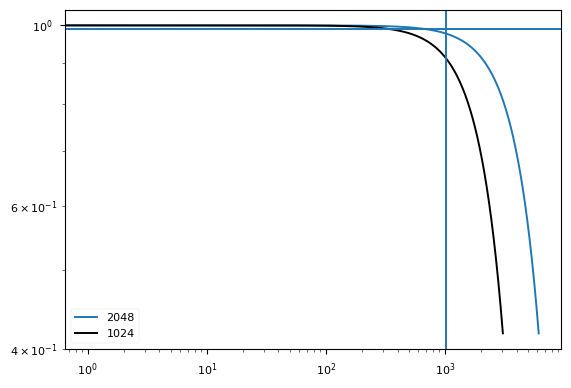

In [155]:
plt.loglog(pw2048**2,label='2048')
plt.loglog(pw1024**2,c='k',
           label='1024')
plt.axvline(1024)
plt.axhline(0.99)
plt.legend(loc='best')

In [119]:
nside = 1024


def psinc(nside, ells):
    thetar = np.sqrt(4*np.pi/(12*nside**2))
    
    res =  np.sinc(thetar*ells/(2*np.pi))   
    
    return res

In [121]:
t1024 = psinc(1024,ells)
t2048 = psinc(2048,ells)

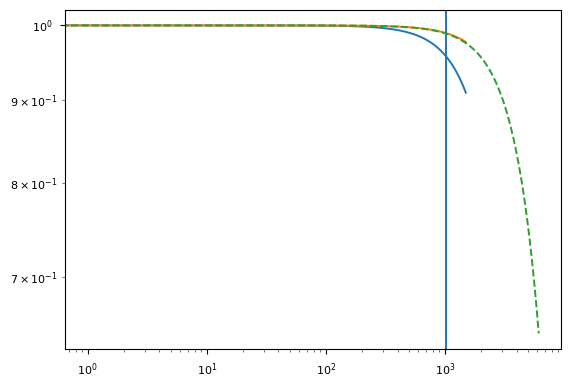

In [125]:
plt.loglog(t1024)
plt.loglog(t2048)
plt.axvline(1024)

plt.loglog(pw2048,label='2048',
           ls='--')

## Full comparison with `NaMaster`

We observe that the agreement is fairly good, when measurement is corrected for $f_{\rm sky}$. However for full comparison, we use `NaMaster`.

In [11]:
import pymaster as nmt

### Estimate $\tilde{C} (\ell)$ using `NaMaster`

In [12]:
# setup NmtField object

# extract apodized masks 

mask_bool1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)
mask_bool2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_bool.hpx.fits", dtype=bool)

mask_apod1 = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/mask_apod.hpx.fits")
mask_apod2 = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/mask_apod.hpx.fits")

mask_nu1 = np.where(mask_bool1, 1, 0) * mask_apod1
mask_nu2 = np.where(mask_bool2, 1, 0) * mask_apod2

# extract data

nu1_map = hp.read_map(f"{data_folder}/{nu1}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6
nu2_map = hp.read_map(f"{data_folder}/{nu2}/2.5e+20_gp20/cib_fullmission.hpx.fits")*1e6

# remove nans
nu1_map = np.where(mask_bool1, nu1_map, 0)
nu2_map = np.where(mask_bool2, nu2_map, 0)

f1 = nmt.NmtField(mask_nu1, [nu1_map], n_iter=0)
f2 = nmt.NmtField(mask_nu2, [nu2_map], n_iter=0)

In [13]:
pcl_nmt = nmt.compute_coupled_cell(f1, f2)

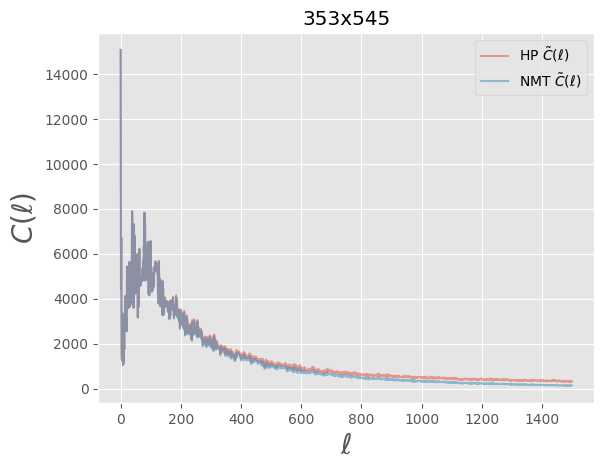

In [14]:
idx = f'{nu1}x{nu2}'

ells = np.arange(LMAX)

plt.plot(ells, 
         cl_cibxcib_fullmission_beam_corrected[f'{idx}'],
         label = r'HP $\tilde{C} (\ell)$',
         alpha = 0.5)

plt.plot(ells, 
         pcl_nmt[0, :LMAX],
         label = r'NMT $\tilde{C} (\ell)$',
         alpha = 0.5)

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f"{idx}")
plt.legend(loc='best')


In [15]:
# fsky from NMT
fsky_nmt = np.mean(f1.get_mask() * f2.get_mask())

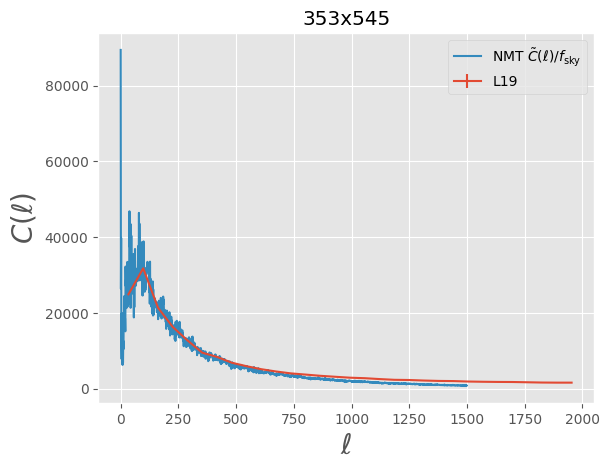

In [17]:
plt.errorbar(data_lenz19['ell'], data_lenz19[f'{idx}'], 
             yerr = data_lenz19[f'd{idx}'],
             label = 'L19')

plt.plot(ells, 
         pcl_nmt[0,:LMAX]/fsky_nmt,
         label = r'NMT $\tilde{C} (\ell)/f_{\rm sky}$')

plt.xlabel(r"$\ell$", fontsize = 20)
plt.ylabel(r"$C (\ell)$", fontsize = 20)
plt.title(f"{idx}")
plt.legend(loc='best')


#### Mode-coupling matrix calculation

In [50]:
nside = 1024

In [42]:
delta_ell = 64
b = nmt.NmtBin.from_nside_linear(1024, nlb=delta_ell)

In [43]:
# NaMaster workspace
w = nmt.NmtWorkspace.from_fields(f1, f2, b)

In [44]:
# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()

# Extract bandpower window functions
Bbl = w.get_bandpower_windows().squeeze()

In [51]:
ls = np.arange(3*nside)

# - binning weights for each bandpower
n_bins = b.get_n_bands()
Fls = np.zeros([n_bins, 3*nside])
for i in range(n_bins):
    Fls[i, b.get_ell_list(i)] = b.get_weight_list(i)

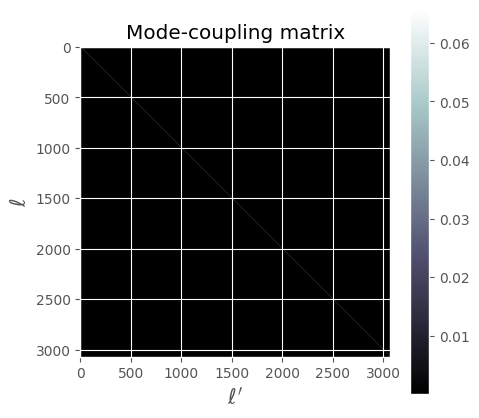

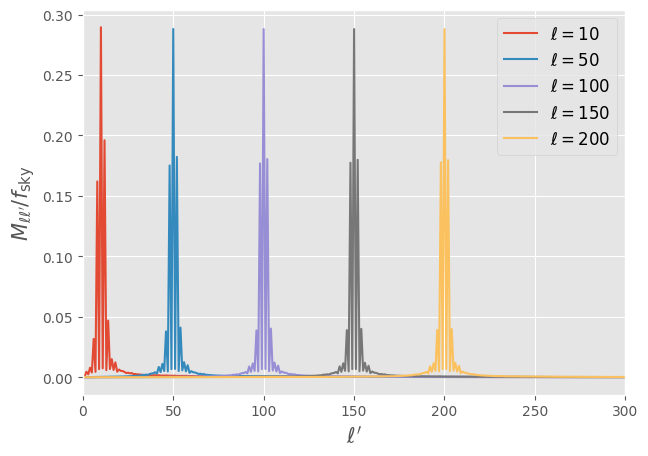

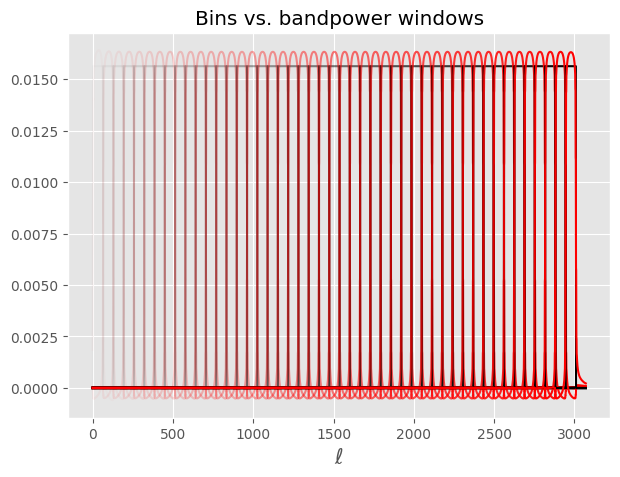

In [52]:


# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()

plt.figure(figsize=(7, 5))
for ll in [10, 50, 100, 150, 200]:
    plt.plot(ls, mcm[ll]/fsky_nmt, label=f'$\\ell={ll}$')
plt.xlabel("$\\ell'$", fontsize=15)
plt.ylabel("$M_{\\ell \\ell'}/f_{\\rm sky}$", fontsize=15)
plt.legend(fontsize=12)
plt.xlim([0, 300])

plt.figure(figsize=(7, 5))
plt.title('Bins vs. bandpower windows')
for i, fl in enumerate(Fls):
    plt.plot(ls, fl, 'k-', alpha=(i+1)/n_bins)
    plt.plot(ls, Bbl[i], 'r-', alpha=(i+1)/n_bins)
plt.xlabel(r'$\ell$', fontsize=15);

In [53]:
print("Sum of MCM over ell': %.5lf" % (np.dot(mcm, np.ones(len(mcm)))[0]))
print("fsky: %.5lf" % fsky_nmt)

Sum of MCM over ell': 0.16052
fsky: 0.16082


0.16287636756896973

In [56]:
.16052/.16082 * fsky_cross[f'{idx}']

0.1625725315394293

In [63]:
cl_dec_nmt = w.decouple_cell(pcl_nmt)

In [65]:
# - effective ells for each bandpower
leff_nmt = b.get_effective_ells()

<ErrorbarContainer object of 3 artists>

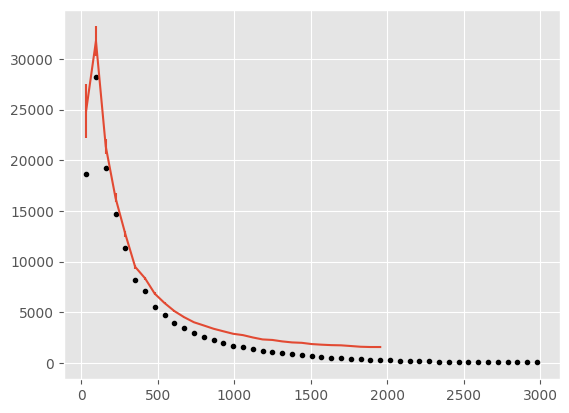

In [77]:
plt.plot(leff_nmt, cl_dec_nmt[0], 'k.')
plt.errorbar(data_lenz19['ell'], data_lenz19[f'{idx}'], 
             yerr = data_lenz19[f'd{idx}'],
             label = 'L19')
# plt.yscale("log")
# plt.xscale("log")